# Learning the Gaussian Curve

This is an implementation of a Gaussian Curve Model, using the Pytorch framework.

In [86]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset


In [87]:
torch.__version__

'1.3.1'

## Defining a Gaussian Curve

In [88]:
def create_gaussian_curve(mean, variance, delta=0.2):
    std = math.sqrt(variance)
    normalize = 1 / (std * math.sqrt(2 * 3.14159))

    def gaussian_curve(x, y):
        term = (x - mean) / std
        expected = normalize * np.exp(-1/2 * term * term)
        return 1 if abs(expected - y) <= delta else 0
    
    return gaussian_curve


## Generating Data

In [89]:
# We don't want the number of negative samples to overwhelm the
# number of positive examples since this can adversly affect the
# ability of the model to learn. Will downsample the dominant
# class.

# Note: c is a param that reduces the harshness of downsampling.
# When c == 1.0, downsampling approximately equalizes the positive
# and negative samples. As c gets larger, the dominant class
# is downsampled less. In the limit, c will perform no downsampling.
def downsample(points, labels, c=1.0):
    pos_mask = labels == 1
    neg_mask = labels == 0

    pos_count = np.sum(pos_mask)
    neg_count = np.sum(neg_mask)
    
    # Note: If values are inequal, gauranteed that one of the
    # following ratios will be 1.0 after clipping, which means
    # that the minority class won't get downsampled.
    neg_to_pos = min(1.0, neg_count / float(pos_count)) ** (1/c)
    pos_to_neg = min(1.0, pos_count / float(neg_count)) ** (1/c)
    
    m = labels.shape[0]
    random_values = np.random.rand(m)
    
    pos_keep_mask = (random_values < neg_to_pos) * pos_mask
    neg_keep_mask = (random_values < pos_to_neg) * neg_mask
    
    keep_mask = pos_keep_mask + neg_keep_mask
    
    return (points[keep_mask, :], labels[keep_mask])
    

In [90]:
def normalizer(X0):
    """
    Generates a normalize function, which can be attached to a model.
    The normalization parameters are based on the training data. The model
    will automatically do the work of normalizing the data before it is
    fed into the network.
    
    X0 - The data used to normalize values. The data is of shape d x m, where
         d is the number of features and m is the number of samples.
    """
    
    m = X0.shape[0]
    mean = np.sum(X0, axis=0).reshape(1, -1) / m
    variance = np.sum(X0 * X0, axis=0).reshape(1, -1) / m
    std = np.sqrt(variance)

    def normalize(X):
        return (X - mean) / std

    return normalize
  

In [91]:
num_points = 200

gauss_func = create_gaussian_curve(0.0, 0.05)
points = np.random.rand(num_points, 2) * 4 - 2
labels = np.apply_along_axis(lambda x: gauss_func(x[0], x[1]), axis=1, arr=points)


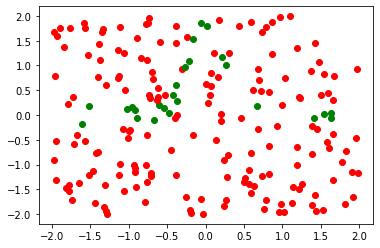

In [92]:
# Let's make a plot to see where the curve is being drawn.
# We will look at the first 5,000 points.

for i in range(min(5000, num_points)):
    point = points[i, :]
    label = labels[i]
    plt.plot(point[0], point[1], 'go' if label == 1 else 'ro')

plt.show()

In [93]:
# Downsample and normalize points
points, labels = downsample(points, labels, c=2)
normalize = normalizer(points)

points = normalize(points)


In [94]:
# Split model into train / test sets.

m = points.shape[0]

random_assignment = np.random.rand(m)
train_mask = random_assignment <= 0.9
test_mask = (random_assignment > 0.9)

train_data = points[train_mask, :]
train_labels = labels[train_mask]

test_data = points[test_mask, :]
test_labels = labels[test_mask]


In [95]:
# Convert to Tensors

train_data = torch.FloatTensor(train_data)
train_labels = torch.FloatTensor(train_labels)

test_data = torch.FloatTensor(test_data)
test_labels = torch.FloatTensor(test_labels)


In [96]:
# Create Data Loader

train_set = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_set, batch_size=1000)

test_set = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_set, batch_size=1000)


## Define Model

In [97]:
class Model(nn.Module):
    
    def __init__(self, layer_sizes):
        super(Model, self).__init__()

        INPUT_SIZE = 2
        OUTPUT_SIZE = 1
        
        sizes = [INPUT_SIZE] + layer_sizes + [OUTPUT_SIZE]
        size_pairs = [(sizes[i-1], sizes[i]) for i in range(1, len(sizes))]

        self.linears = nn.ModuleList([nn.Linear(i, o) for i, o in size_pairs])
    
    def forward(self, X):
        for i, layer in enumerate(self.linears):
            if i != 0:
                X = F.relu(X)

            X = layer(X)
            
        X = torch.sigmoid(X)

        return X


## Train Model

In [105]:
def create_and_train_model(layer_sizes, lr, epochs=1000, logs=True):
    model = Model(layer_sizes=[5, 4])
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(epochs):

        total_loss = 0

        for batch in train_loader:
            inputs, expected = batch

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, expected.reshape(-1, 1))
            loss.backward()

            optimizer.step()

            total_loss += loss.item()

        if i % 50 == 0:
            print(f'Epoch {i + 1}, Loss: {total_loss:.02f}')
    
    return model


In [107]:
hyperparams = [
    { 'layer_sizes': [50, 20, 8],   'lr': 0.0001 },
    { 'layer_sizes': [50, 20, 8],   'lr': 0.001 },
    { 'layer_sizes': [50, 20, 8],   'lr': 0.01 },
    { 'layer_sizes': [80, 50, 20],  'lr': 0.0001 },
    { 'layer_sizes': [80, 50, 20],  'lr': 0.001 },
    { 'layer_sizes': [80, 50, 20],  'lr': 0.01 },
    { 'layer_sizes': [100, 60, 40], 'lr': 0.0001 },
    { 'layer_sizes': [100, 60, 40], 'lr': 0.001 },
    { 'layer_sizes': [100, 60, 40], 'lr': 0.01 },    
]